### **Challenges Faced while building ML & DL models to forecast Solar Radio Flux**
* **Not enough data**: The dataset is limited when it came to F10.7 consisted of few hundred rows which made it difficult to build ML models out of it
* **Complexity**: ML/DL models struggled with overfitting, high variance, and lacked generalization due to the small dataset and the non-linear, cyclical nature of solar activity.


### **Changed Approach for predicting SFU**

Given the challenges, we adopted a physically-motivated, model-based **Statistical Modelling** approach.
We referenced key papers:

Clette (2021): A second-order polynomial relationship between SSN and SFU.

Tiwari & Kumar (2018): Proposed polynomial models mapping SSN to SFU.

Clette Model (2021):

**SFU = 62.87 + 0.6279 × SSN + 6.141 × 10⁻⁵ × SSN²**

Tiwari-Kumar Model (simplified here):

**SFU = 62.51 + 0.6422 × SSN**

We also used the Hathaway Function (2015) to model SSN forecasts for Solar Cycle 25 using McIntosh+ 2023 parameters.

To know more about the approach refer to these papers for the relationship between SFU and SSN:

+ Clette 2021: https://www.swsc-journal.org/articles/swsc/pdf/2021/01/swsc200021.pdf

+ Tiwari and Kumar https://journals.aijr.org/index.php/ias/article/view/751/172

+ We use the Clette 2021 model Equation (2) with a 2nd order polynomial.

### **Importing Libraries**

In [ ]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
import os
import sys


#Plotly imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
pio.renderers.default = 'browser'


### **Loading data from NOAA**

In [ ]:
noaa_obs = pd.read_json('/content/drive/MyDrive/Deekshitha/Datasets/Done_Dusted/observed-solar-cycle-indices.json')

#convert times to matplotlib format
noaa_obs_times=[]

#make datetime objects from file times
for i in np.arange(0,len(noaa_obs)):
    year=int(noaa_obs['time-tag'][i][0:4])
    month=int(noaa_obs['time-tag'][i][5:7])

    noaa_obs_times.append(datetime.datetime(year,month,1))

noaa_obs_times_num=mdates.date2num(noaa_obs_times)

SSN_obs=noaa_obs['ssn']
SFU_obs=noaa_obs['f10.7']

#set older SFU values to nan
SFU_obs[:3069]=np.nan

noaa_obs

<ipython-input-6-cd6586584a39>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.00,-1.0,NaN,-1.0
1,1749-02,104.3,-1.0,-1.00,-1.0,NaN,-1.0
2,1749-03,116.7,-1.0,-1.00,-1.0,NaN,-1.0
3,1749-04,92.8,-1.0,-1.00,-1.0,NaN,-1.0
4,1749-05,141.7,-1.0,-1.00,-1.0,NaN,-1.0
...,...,...,...,...,...,...,...
3310,2024-11,152.5,-1.0,144.97,-1.0,199.95,-1.0
3311,2024-12,154.5,-1.0,134.90,-1.0,196.90,-1.0
3312,2025-01,137.0,-1.0,145.23,-1.0,189.39,-1.0
3313,2025-02,154.6,-1.0,152.64,-1.0,184.31,-1.0


### **Figure out relationship for SSN to SFU**

In [ ]:
#define models to convert SSN to SFU
def tk_model(SSN_in):
    SFU_out = 62.51 + 0.6422*SSN_in
    return SFU_out

def clette_model(SSN_in):
    SFU_out = 62.87 + 0.6279*SSN_in +6.141*1e-5*SSN_in**2 #equation 2 in Clette 2021 for order 2 polynomial
    return SFU_out

#NOAA model
#SFU_NOAA_1=67.00 + 0.4903*SSN < SSN 50
#SFU_NOAA_2=56.06 + 0.7092*SSN > SSN 50

#Johnson
#SFU_J=60.72 + 0.900*SSN

#Tiwari Kumar 2018 model2
#SFU_TK2=65.6605 + 0.500687*SSN + 1.21647*1e-3*SSN**2- 2.71853*1e-6*SSN**3

### **Data Preparation**

In [ ]:
#NOAA Predicted Data File
noaa_pred = pd.read_json('/content/drive/MyDrive/Deekshitha/Datasets/Done_Dusted/predicted-solar-cycle.json')

#first few datapoints are weird, so I cut them off
noaa_pred=noaa_pred.drop(np.arange(0,12),axis=0)


noaa_pred_times=[]



#make datetime objects from file times
for i in np.arange(12,len(noaa_pred)+12):
    year=int(noaa_pred['time-tag'][i][0:4])
    month=int(noaa_pred['time-tag'][i][5:7])
    noaa_pred_times.append(datetime.datetime(year,month,1))

#noaa_pred

noaa_pred_ssn=noaa_pred['predicted_ssn']
noaa_pred_sfu=noaa_pred['predicted_f10.7']

SFU_pred=np.array(noaa_pred_sfu)
SSN_pred=np.array(noaa_pred_ssn)

### **Analysing the relationship between Solar Radio Flux and Sunspot Number**

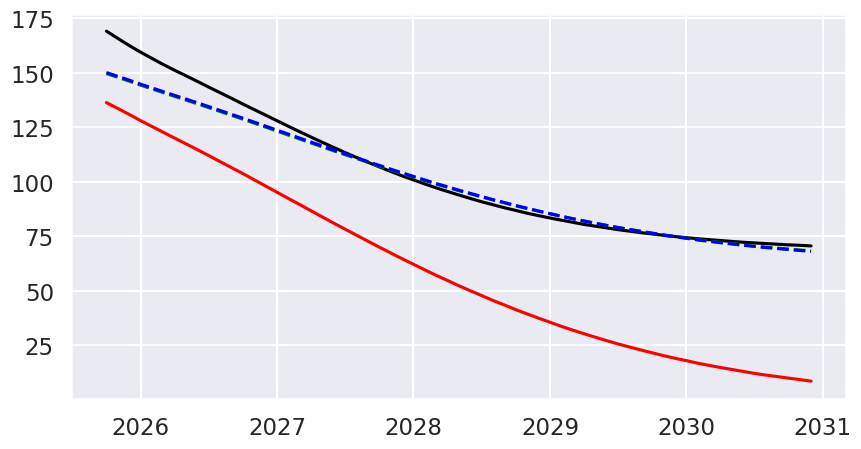

In [ ]:
sns.set_context('talk')
sns.set_style('darkgrid')
fig=plt.figure(1,figsize=(10,5),dpi=100)

plt.plot(noaa_pred_times,SSN_pred,'r')
plt.plot(noaa_pred_times,SFU_pred,'k')
plt.plot(noaa_pred_times,clette_model(SSN_pred),'g--')
plt.plot(noaa_pred_times,tk_model(SSN_pred),'b--')

### **Defining Hathaway function for SSN from McIntosh+ 2023**

In [ ]:
def hathaway(x,x0, a, b, c):
    #Hathaway 2015 equation 6 page 40
    #average cycle sunspot number
    #4 free parameters A, b, c, t0

    x1=(mdates.date2num(x)-mdates.date2num(x0))/30.42

    hatfunc=a*(((x1)/b)**3) * 1/(np.exp((((x1)/b)**2))-c)

    return hatfunc

#create an array with 1 day resolution between start and end
start_25=datetime.datetime(2020,6,1)
end_25=datetime.datetime(2033,1,1)
times_25_daily = [ start_25 + datetime.timedelta(days=n) for n in range(int ((end_25 - start_25).days))]

#this sets the solar cycle 25 start time
sc_25_start_time=datetime.datetime(2020,8,1)



#MC 23 model
a=365
aerr68=33 #for 1sigma
b=43.3#60
c=0.71

print('a,b,c:', a,b,c)
print('range for a:',a-aerr68,a+aerr68)

#MC 22 model
#a=363
#aerr68=38 #MC20: 325 -> 170 max,
#b=60
#c=0.8
#print('Hathaway function parameters')
#print('a,b,c:', a,b,c)

#create daily SSN prediction
SSN_mc_prediction=hathaway(times_25_daily, sc_25_start_time,a,b,c)

print('Maximum SSN in McIntosh+ 2023 forecast:', int(np.max(SSN_mc_prediction)))


##make SFU based on SSN prediction

SFU_mc_prediction_1= tk_model(SSN_mc_prediction)
SFU_mc_prediction_2= clette_model(SSN_mc_prediction)

print()
print('maximum SFU based on McIntosh forecast with TK and Clette models')
print(int(np.max(SFU_mc_prediction_1)))
print(int(np.max(SFU_mc_prediction_2)))

a,b,c: 365 43.3 0.71
range for a: 332 398
Maximum SSN in McIntosh+ 2023 forecast: 183

maximum SFU based on McIntosh forecast with TK and Clette models
180
180


<ipython-input-16-15ad1c063eb0>:42: MatplotlibDeprecationWarning:

The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.



[62.43030888 62.43414607 62.43785893 ... 62.5786512  62.57833857
 62.57802728]


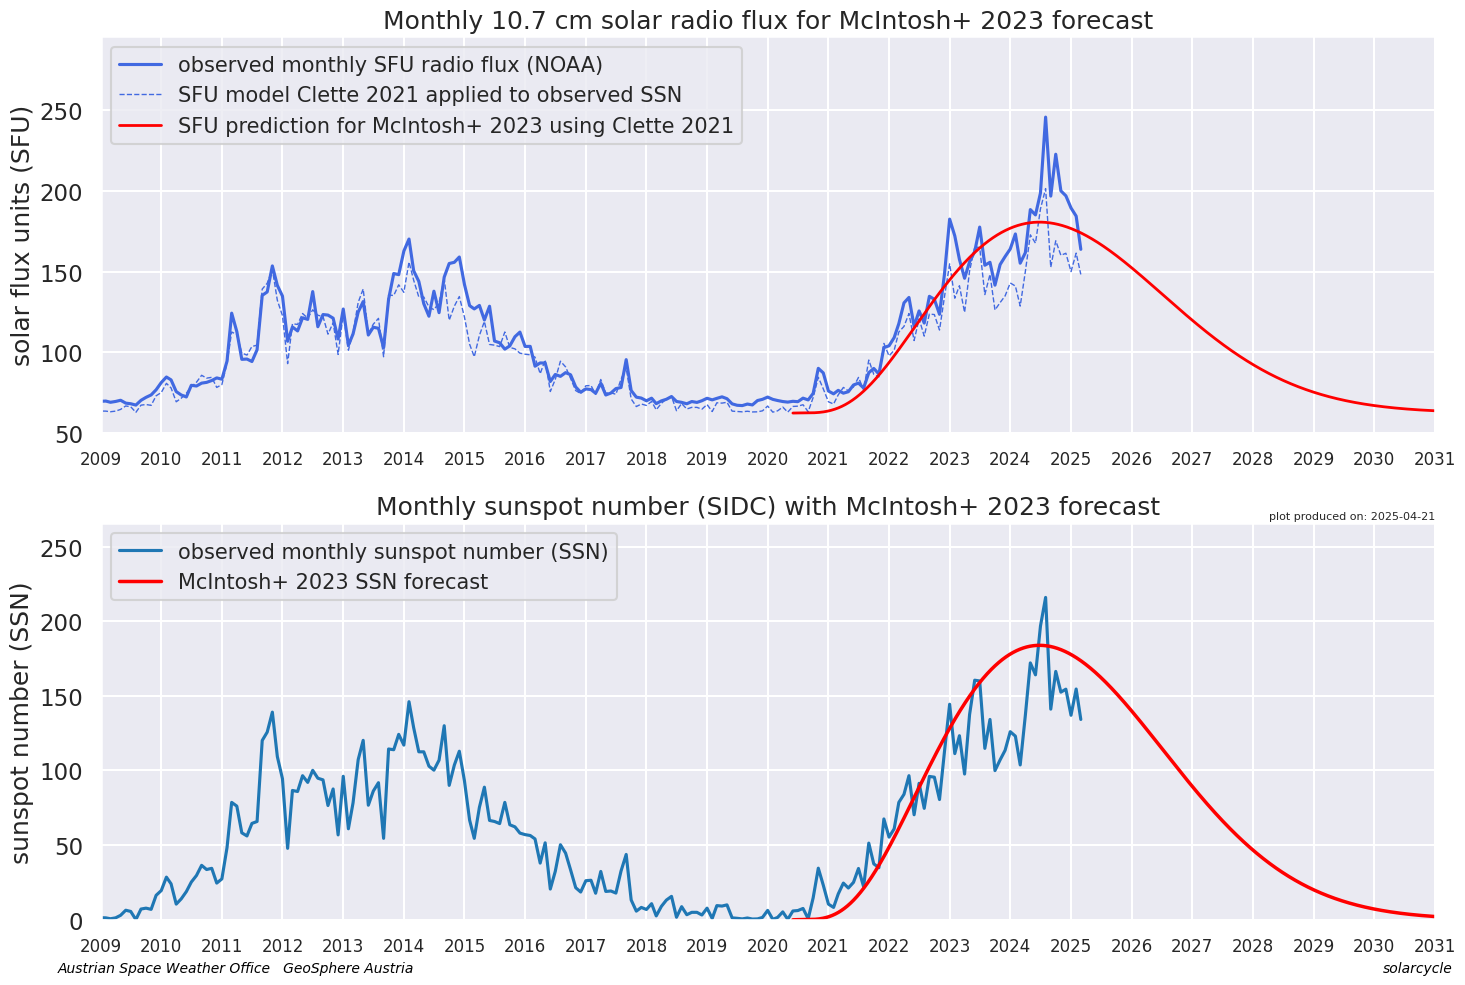

In [ ]:
years=np.arange(2005,2040)
yearly_start_times=[datetime.datetime(year,1,1) for year in years]

sns.set_context('talk')
sns.set_style('darkgrid')

fig1, (ax1, ax2) = plt.subplots(2, figsize=(15,10),dpi=100)

############

ax1.set_title('Monthly 10.7 cm solar radio flux for McIntosh+ 2023 forecast')

ax1.plot(noaa_obs_times,SFU_obs,'-',label='observed monthly SFU radio flux (NOAA)',color='royalblue')
ax1.plot(noaa_obs_times,clette_model(SSN_obs),'--',lw=1,label='SFU model Clette 2021 applied to observed SSN',color='royalblue')
ax1.plot(times_25_daily,SFU_mc_prediction_1,'r-',alpha=1,linewidth=2,label='SFU prediction for McIntosh+ 2023 using Clette 2021')


#ax2.plot(noaa_pred_times,SFU_pred,'b-',lw=2,label='NOAA prediction')
#ax2.plot(times_25_daily,SFU_mc_prediction_2,'k-',alpha=1,linewidth=1,label='TK model for McIntosh/Leamon 2022')
#ax2.plot(noaa_obs_times,tk_model(SSN_obs),'k--',lw=1, label='TK model')


ax1.legend(loc=2,fontsize=15)



#maximum of last 20 years
ax1.set_ylim(50,np.nanmax(SFU_obs[-20*12:])+50)
ax1.set_ylabel('solar flux units (SFU)')

ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)
ax1.set_xticks(yearly_start_times)
ax1.set_xticklabels([dt.strftime('%Y') for dt in yearly_start_times], fontsize=12)
#plt.xlabel('Year',fontsize=12)

ax1.set_xlim(datetime.datetime(2009,1,1),datetime.datetime(2031,1,1))

##################################

ax2.plot_date(noaa_obs_times,SSN_obs,'-', label='observed monthly sunspot number (SSN)')
ax2.plot(times_25_daily,SSN_mc_prediction,'-r',alpha=1,linewidth=2.5,label='McIntosh+ 2023 SSN forecast')

ax2.set_ylabel('sunspot number (SSN)')
#maximum of last 20 years
ax2.set_ylim(0,np.nanmax(SSN_obs[-20*12:]+50))
ax2.legend(loc=2,fontsize=15)
ax2.set_title('Monthly sunspot number (SIDC) with McIntosh+ 2023 forecast')

ax2.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)
ax2.set_xticks(yearly_start_times)
ax2.set_xticklabels([dt.strftime('%Y') for dt in yearly_start_times], fontsize=12)
ax2.set_xlim(datetime.datetime(2009,1,1),datetime.datetime(2031,1,1))


fsize=14
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'solarcycle', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.annotate('plot produced on: '+str(datetime.datetime.utcnow())[0:10],xy=(1.0,1.01),xycoords='axes fraction',fontsize=8,ha='right')

plt.tight_layout()
plt.savefig('sfu_prediction.png',dpi=100)


In [ ]:
predicted_sfu=pd.DataFrame(times_25_daily, columns=['time'])
predicted_sfu['predicted_sfu']=SFU_mc_prediction_1
predicted_sfu

,time,predicted_sfu
0,2020-06-01,62.430309
1,2020-06-02,62.434146
2,2020-06-03,62.437859
3,2020-06-04,62.441449
4,2020-06-05,62.444920
...,...,...
4592,2032-12-27,62.579280
4593,2032-12-28,62.578965
4594,2032-12-29,62.578651
4595,2032-12-30,62.578339


### **NASA Forecast Comparison**

In [ ]:
nasa_test = pd.read_csv('/content/drive/MyDrive/Deekshitha/Datasets/Done_Dusted/NASA.csv')
nasa_test.rename(columns={'Unnamed: 0': 'Year','Unnamed: 1': 'Month','95.00%': 'SF10.7'}, inplace=True)
nasa_test = nasa_test.iloc[:, :3]
nasa_test['Year']=nasa_test.Year.astype(str)
nasa_test['Year'] = nasa_test['Year'].str.split('.').str[0]
nasa_test['Month'] = pd.to_datetime(nasa_test['Month'], format='%b', errors='coerce').dt.month
nasa_test['Month']=nasa_test.Month.astype(str)
nasa_test['time-tag'] = pd.to_datetime(nasa_test['Year'] + '-' + nasa_test['Month'])
nasa_test.head()

,Year,Month,F10.7(95%),time-tag
0,2019,12,69.7,2019-12-01
1,2020,1,70.2,2020-01-01
2,2020,2,71.1,2020-02-01
3,2020,3,72.1,2020-03-01
4,2020,4,73.2,2020-04-01


In [ ]:
# NOAA Dataset for 25th Solar Cycle
file_path = '/content/drive/MyDrive/Deekshitha/Datasets/Done_Dusted/observed-solar-cycle-indices.json'
df = pd.read_json(file_path)


In [ ]:
df1=df.drop(df[df['f10.7'] == -1.0].index, axis=0)
df1['time-tag'] = pd.to_datetime(df1['time-tag'])

In [ ]:
df_filtered = df1[df1['time-tag'].dt.year > 2019]
df_filtered.head()

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
3252,2020-01-01,6.2,2.2,5.94,2.3,72.32,69.5
3253,2020-02-01,0.2,2.7,0.38,2.8,70.90,69.8
3254,2020-03-01,1.5,3.0,1.19,3.1,70.19,70.1
3255,2020-04-01,5.2,3.6,4.83,3.6,69.56,70.5
3256,2020-05-01,0.2,5.6,0.00,5.3,69.21,71.7


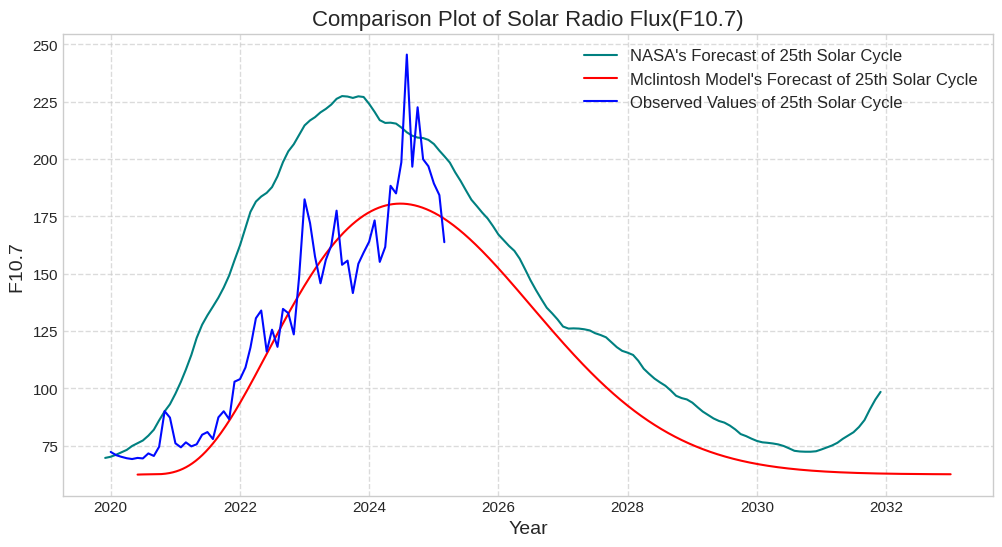

In [ ]:
# Set a beautiful style using seaborn
sns.set_theme(style="dark")
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Another elegant style

# Create the line plot with enhanced aesthetics
plt.plot('time-tag','F10.7(95%)',data=nasa_test, color="#008080", linewidth=1.5,label="NASA's Forecast of 25th Solar Cycle" ) # Cornflower blue
plt.plot('time','predicted_sfu',data=predicted_sfu, color="#FF0000", linewidth=1.5,label="Mclintosh Model's Forecast of 25th Solar Cycle" )
plt.plot('time-tag','f10.7',data=df_filtered, color="#0009FF", linewidth=1.5, label="Observed Values of 25th Solar Cycle") # Light blue
# Add a subtle gradient fill under the curve
#plt.fill_between(years, sunspot_numbers, alpha=0.2, color="#ADD8E6") # Light blue

# Customize the plot elements
plt.xlabel("Year", fontsize=14)
plt.ylabel("F10.7 ", fontsize=14)
plt.title("Comparison Plot of Solar Radio Flux(F10.7)", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

### Comparison plot for Last 2 Solar Cycles